In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error

from models import AR_RNN, compile_and_fit_tf


2023-05-11 16:02:41.393727: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### data setup

In [3]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [4]:
area = "city of london"
monthly_data = utils.load_interpolated_data()

area_data = utils.get_area(monthly_data, area)


In [5]:
def format_data_for_RNN(area_data, cols, lookback, lookforward):
    train_df, test_df = train_test_split(area_data[cols],
                                         test_size=0.3,
                                         shuffle=False)

    # normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_df[cols] = scaler.fit_transform(train_df[cols])
    test_df[cols] = scaler.transform(test_df[cols])

    X_train, y_train = utils.create_windowed_dataset(train_df, cols, lookback,
                                                     lookforward)
    X_test, y_test = utils.create_windowed_dataset(test_df, cols, lookback,
                                                   lookforward)
    return train_df, test_df, X_train, y_train, X_test, y_test, scaler
    # return {'train_df':train_df, 'test_df':test_df, 'X_train':X_train, 'y_train':y_train, 'X_test':X_test, 'y_test':y_test, 'scaler':scaler}


In [6]:
def plot_inputs_outputs(area_data,
                        ground_truth,
                        train_ts,
                        test_ts,
                        cols,
                        col_idx,
                        lookback,
                        lookforward,
                        fwd_offset,
                        title=''):
    """ Args: 
            area_data: dataframe containing dates
            ground_truth: dataframe containing ground truth data
            train_ts: np array containing time series in the shape 
                (n_samples, lookback timesteps, n_features)
            test_ts: np array containing time series in the shape 
                (n_samples, lookforward timesteps, n_features)
            cols (str list): list of strings of features 
            col_idx (int): index of the feature to be plotted 
            lookback (int): number of timesteps in the lookback 
            lookforward (int): number of timesteps in the lookforward
            fwd_idx (int): which forward prediction/sample to plot
            title (str)
    """
    # fwd_idx = fwd_idx % lookforward
    col = cols[col_idx]
    plt.plot(area_data.date, ground_truth[col])
    plt.plot(area_data.date[range(lookback, lookback + len(train_ts))],
             train_ts[:, col_idx])
    plt.plot(
        area_data.date[range(
            lookback * 2 + fwd_offset + lookforward + len(train_ts),
            lookback * 2 + fwd_offset + lookforward + len(train_ts) +
            len(test_ts))], test_ts[:, col_idx])
    plt.title(title)

In [7]:
def plot_cumulative(area_data,
                    ground_truth_diff,
                    train_ts_diff,
                    test_ts_diff,
                    cols,
                    col_idx,
                    lookback,
                    lookforward,
                    fwd_offset=0,
                    title=''):
    init_train_offset = area_data.loc[lookback, 'average_price']
    init_test_offset = area_data.loc[lookback * 2 + fwd_offset + lookforward +
                                     len(train_ts_diff), 'average_price']
    plot_inputs_outputs(
        area_data,
        np.cumsum(ground_truth_diff) + init_train_offset,
        np.cumsum(train_ts_diff).reshape(-1, 1) + init_train_offset,
        np.cumsum(test_ts_diff).reshape(-1, 1) + init_test_offset, cols,
        col_idx, lookback, lookforward, fwd_offset, title)


## single-step prediction

### predict raw price

#### data setup

In [8]:
cols = ["average_price"]
lookback = 12
lookforward = 1
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [9]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(197, 12, 1)
(197, 1, 1)
(78, 12, 1)
(78, 1, 1)


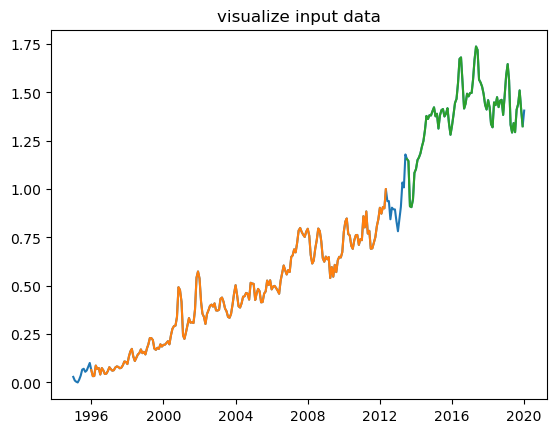

In [10]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [11]:
ar_rnn_model = AR_RNN(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_rnn_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


2023-05-11 16:03:02.986606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
7/7 [==============================] - 3s 101ms/step - loss: 0.0711 - mean_absolute_error: 0.2174 - val_loss: 0.5575 - val_mean_absolute_error: 0.7217
Epoch 2/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0168 - mean_absolute_error: 0.0951 - val_loss: 0.6540 - val_mean_absolute_error: 0.7896
Epoch 3/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0107 - mean_absolute_error: 0.0788 - val_loss: 0.3582 - val_mean_absolute_error: 0.5724
Epoch 4/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0101 - mean_absolute_error: 0.0796 - val_loss: 0.3944 - val_mean_absolute_error: 0.6070
Epoch 5/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0076 - mean_absolute_error: 0.0665 - val_loss: 0.2711 - val_mean_absolute_error: 0.4976
Epoch 6/50
7/7 [==============================] - 0s 25ms/step - loss: 0.0072 - mean_absolute_error: 0.0665 - val_loss: 0.2520 - val_mean_absolute_error: 0.4806
Epoch 7/50
7/7 [=================

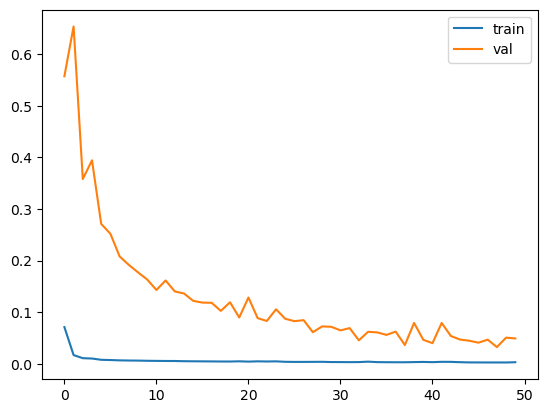

In [12]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

3/3 [==============================] - 0s 5ms/step


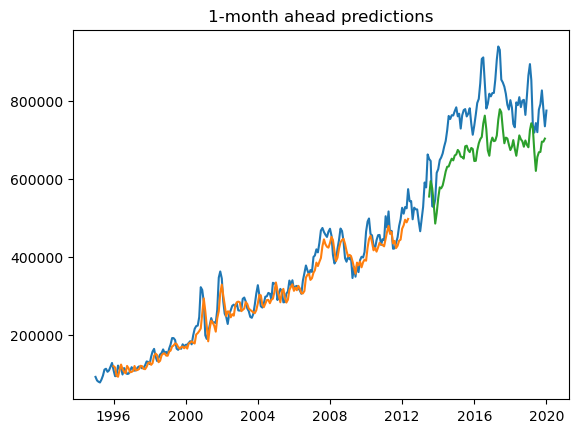

In [13]:
pred_train = ar_rnn_model.predict(X_train)  #[:, -1]
pred_test = ar_rnn_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])

plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='1-month ahead predictions')


In [14]:
y_1mo_train_rescaled = scaler.inverse_transform(y_train[:, 0])
y_1mo_test_rescaled = scaler.inverse_transform(y_test[:, 0])

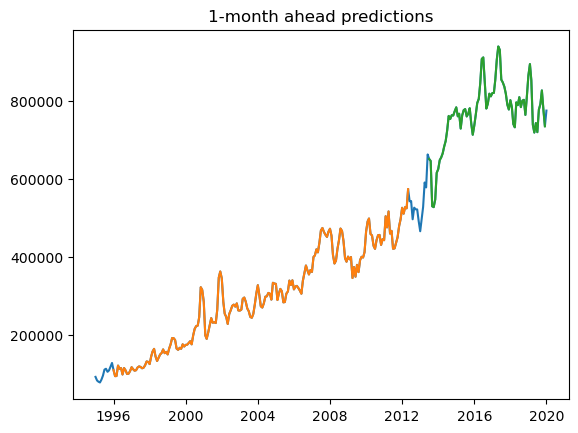

In [15]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_1mo_train_rescaled,
                    test_ts=y_1mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='ground truth')


compute RMSE

In [16]:
print('Train RMSE: {}'.format(
    np.sqrt(mean_squared_error(pred_1mo_train_rescaled, y_1mo_train_rescaled))))
print('Test RMSE: {}'.format(
    np.sqrt(mean_squared_error(pred_1mo_test_rescaled, y_1mo_test_rescaled))))


Train RMSE: 26568.632616612456
Test RMSE: 109941.60007677288


### multiple features

#### data

In [17]:
cols = [
    'average_price', 'year', 'month', 'average_price_d1', 'median_salary',
    'population_size', 'number_of_jobs', 'no_of_houses'
]  # w no nans

lookback = 12
lookforward = 1
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [18]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(197, 12, 8)
(197, 1, 8)
(78, 12, 8)
(78, 1, 8)


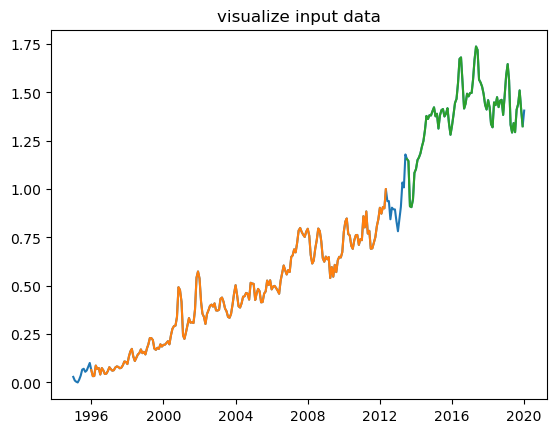

In [19]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [20]:
ar_rnn_model = AR_RNN(
    units=256,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_rnn_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=100,
                             patience=20)


Epoch 1/100
7/7 [==============================] - 2s 136ms/step - loss: 0.1642 - mean_absolute_error: 0.3082 - val_loss: 0.8005 - val_mean_absolute_error: 0.6775
Epoch 2/100
7/7 [==============================] - 0s 17ms/step - loss: 0.0406 - mean_absolute_error: 0.1571 - val_loss: 0.4397 - val_mean_absolute_error: 0.4762
Epoch 3/100
7/7 [==============================] - 0s 21ms/step - loss: 0.0242 - mean_absolute_error: 0.1204 - val_loss: 0.4057 - val_mean_absolute_error: 0.4864
Epoch 4/100
7/7 [==============================] - 0s 18ms/step - loss: 0.0135 - mean_absolute_error: 0.0900 - val_loss: 0.4032 - val_mean_absolute_error: 0.4475
Epoch 5/100
7/7 [==============================] - 0s 20ms/step - loss: 0.0093 - mean_absolute_error: 0.0753 - val_loss: 0.3650 - val_mean_absolute_error: 0.4199
Epoch 6/100
7/7 [==============================] - 0s 25ms/step - loss: 0.0080 - mean_absolute_error: 0.0672 - val_loss: 0.3532 - val_mean_absolute_error: 0.4058
Epoch 7/100
7/7 [==========

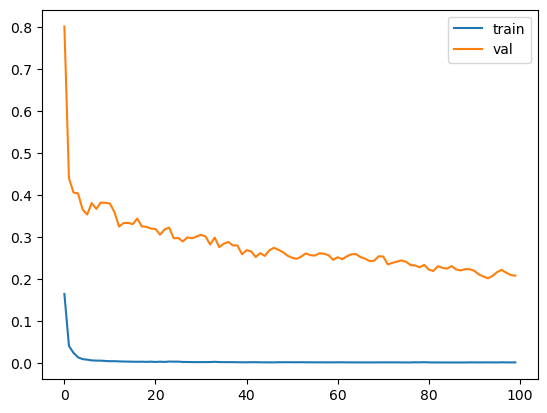

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [22]:
pred_train = ar_rnn_model.predict(X_train)  #[:, -1]
pred_test = ar_rnn_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])

3/3 [==============================] - 0s 8ms/step


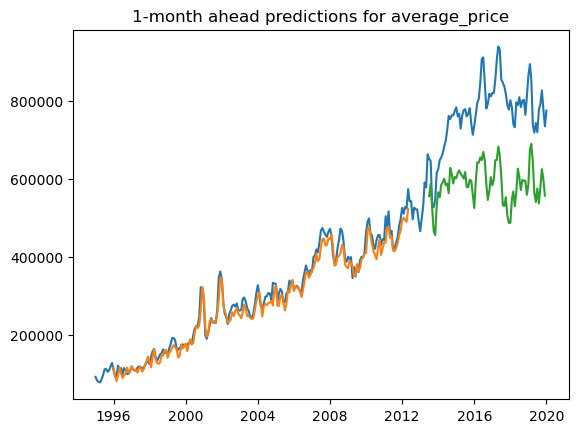

In [23]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


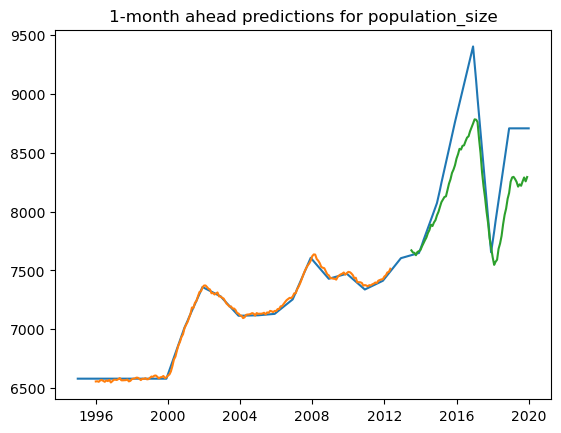

In [24]:
col_idx = 5
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


In [25]:
y_1mo_train_rescaled = scaler.inverse_transform(y_train[:, 0])
y_1mo_test_rescaled = scaler.inverse_transform(y_test[:, 0])

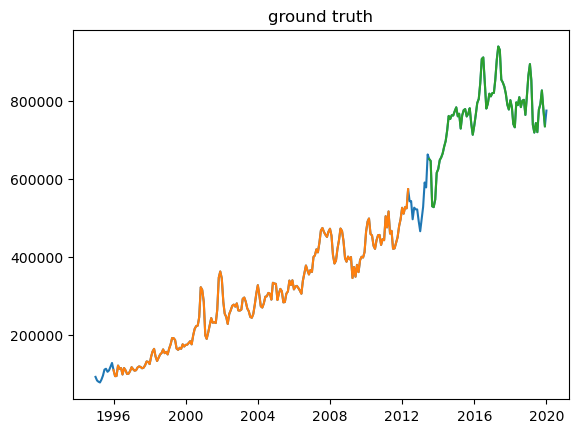

In [26]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_1mo_train_rescaled,
                    test_ts=y_1mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='ground truth')


compute RMSE

In [27]:
print('Train RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_train_rescaled[:, 0],
                           y_1mo_train_rescaled[:, 0]))))
print('Test RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_test_rescaled[:, 0],
                           y_1mo_test_rescaled[:, 0]))))


Train RMSE: 20307.664868205073
Test RMSE: 194537.6407737272


### predict diff

#### data

In [28]:
cols = ['average_price_d1']
lookback = 12
lookforward = 1
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [29]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(197, 12, 1)
(197, 1, 1)
(78, 12, 1)
(78, 1, 1)


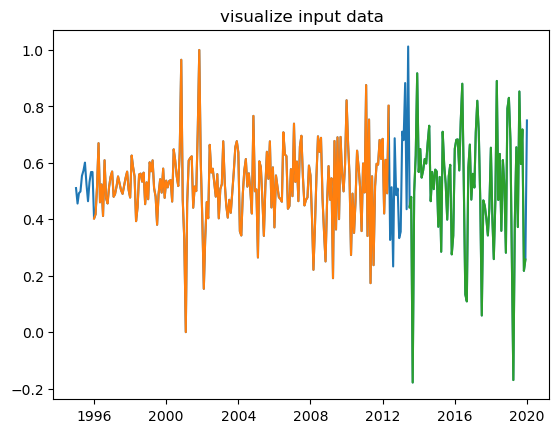

In [30]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [31]:
ar_rnn_model = AR_RNN(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_rnn_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


Epoch 1/50
7/7 [==============================] - 4s 130ms/step - loss: 0.1119 - mean_absolute_error: 0.2831 - val_loss: 0.0842 - val_mean_absolute_error: 0.2252
Epoch 2/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0470 - mean_absolute_error: 0.1818 - val_loss: 0.0911 - val_mean_absolute_error: 0.2457
Epoch 3/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0237 - mean_absolute_error: 0.1176 - val_loss: 0.0956 - val_mean_absolute_error: 0.2315
Epoch 4/50
7/7 [==============================] - 0s 22ms/step - loss: 0.0273 - mean_absolute_error: 0.1280 - val_loss: 0.0785 - val_mean_absolute_error: 0.2271
Epoch 5/50
7/7 [==============================] - 0s 19ms/step - loss: 0.0257 - mean_absolute_error: 0.1271 - val_loss: 0.0733 - val_mean_absolute_error: 0.2182
Epoch 6/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0194 - mean_absolute_error: 0.1083 - val_loss: 0.0721 - val_mean_absolute_error: 0.2064
Epoch 7/50
7/7 [=================

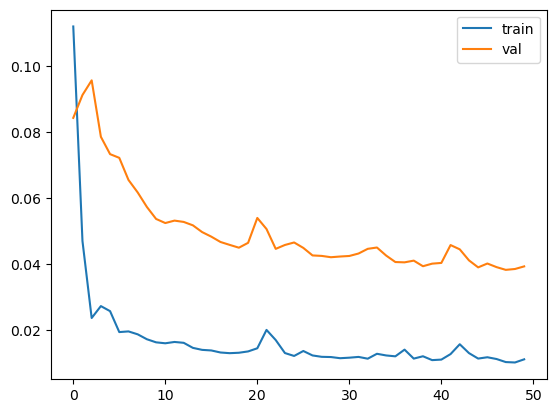

In [32]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [33]:
pred_train = ar_rnn_model.predict(X_train)  #[:, -1]
pred_test = ar_rnn_model.predict(X_test)  #[:, -1]

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])

3/3 [==============================] - 0s 7ms/step


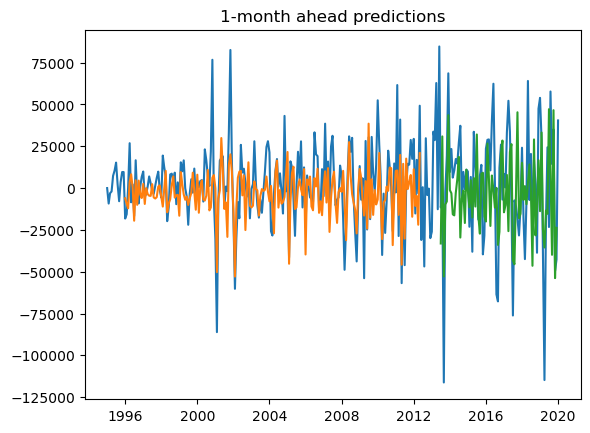

In [34]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=col_idx,
                    title='1-month ahead predictions')

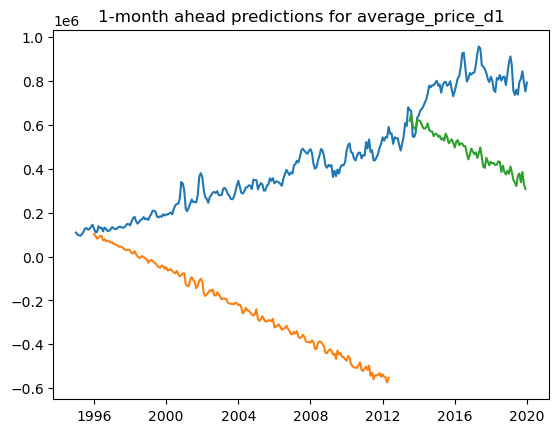

In [35]:
col_idx = 0
plot_cumulative(area_data=area_data,
                ground_truth_diff=pd.concat([train_df[cols], test_df[cols]]),
                train_ts_diff=pred_1mo_train_rescaled,
                test_ts_diff=pred_1mo_test_rescaled,
                cols=cols,
                col_idx=col_idx,
                lookback=lookback,
                lookforward=lookforward,
                fwd_offset=0,
                title=f'1-month ahead predictions for {cols[col_idx]}')


## autoregressive prediction

### predict raw

#### data setup

In [36]:
cols = ["average_price"]
lookback = 12
lookforward = 12
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [37]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(186, 12, 1)
(186, 12, 1)
(67, 12, 1)
(67, 12, 1)


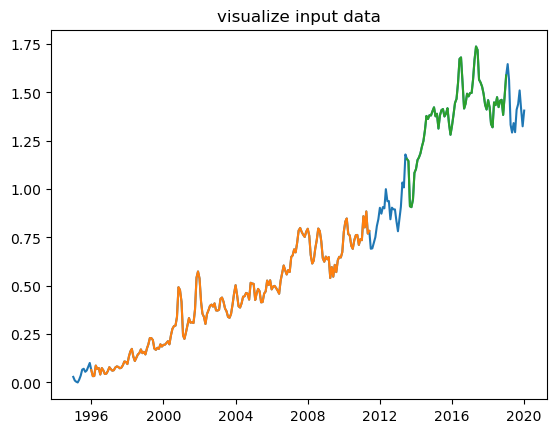

In [38]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [39]:
ar_rnn_model = AR_RNN(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_rnn_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


Epoch 1/50
6/6 [==============================] - 10s 290ms/step - loss: 0.1751 - mean_absolute_error: 0.2987 - val_loss: 0.6534 - val_mean_absolute_error: 0.7943
Epoch 2/50
6/6 [==============================] - 0s 33ms/step - loss: 0.0406 - mean_absolute_error: 0.1486 - val_loss: 0.7608 - val_mean_absolute_error: 0.8587
Epoch 3/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0178 - mean_absolute_error: 0.1048 - val_loss: 0.3656 - val_mean_absolute_error: 0.5869
Epoch 4/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0150 - mean_absolute_error: 0.0974 - val_loss: 0.4830 - val_mean_absolute_error: 0.6792
Epoch 5/50
6/6 [==============================] - 0s 26ms/step - loss: 0.0118 - mean_absolute_error: 0.0814 - val_loss: 0.5145 - val_mean_absolute_error: 0.7019
Epoch 6/50
6/6 [==============================] - 0s 26ms/step - loss: 0.0099 - mean_absolute_error: 0.0765 - val_loss: 0.3868 - val_mean_absolute_error: 0.6054
Epoch 7/50
6/6 [================

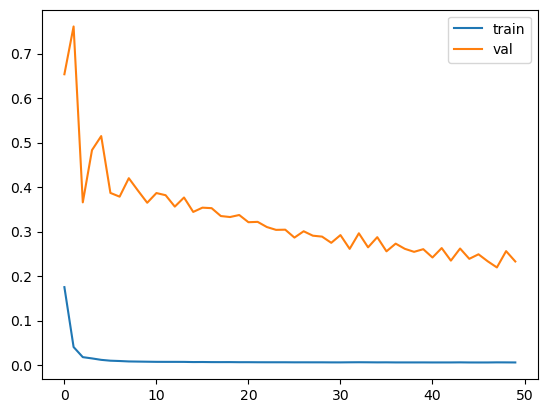

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [41]:
pred_train = ar_rnn_model.predict(X_train)  #[:, -1]
pred_test = ar_rnn_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])
pred_12mo_train_rescaled = scaler.inverse_transform(pred_train[:, -1])
pred_12mo_test_rescaled = scaler.inverse_transform(pred_test[:, -1])


3/3 [==============================] - 0s 5ms/step


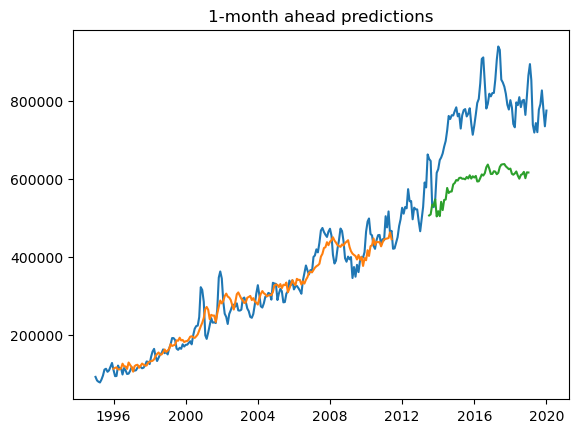

In [42]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='1-month ahead predictions')

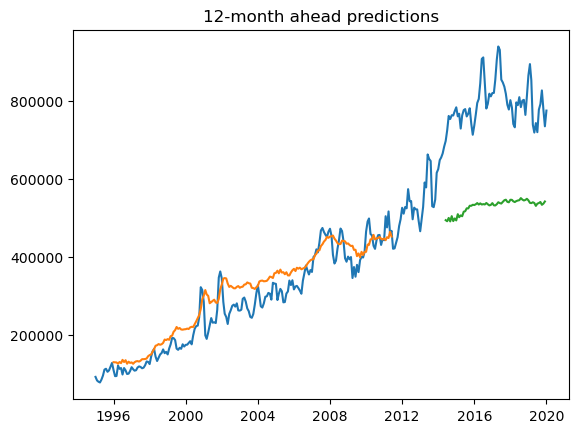

In [43]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_12mo_train_rescaled,
                    test_ts=pred_12mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=11,
                    title='12-month ahead predictions')


In [44]:
y_1mo_train_rescaled = scaler.inverse_transform(y_train[:, 0])
y_1mo_test_rescaled = scaler.inverse_transform(y_test[:, 0])
y_12mo_train_rescaled = scaler.inverse_transform(y_train[:, -1])
y_12mo_test_rescaled = scaler.inverse_transform(y_test[:, -1])

In [45]:
y_1mo_train_rescaled.shape

(186, 1)

In [46]:
print('Train 1mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_train_rescaled[:, 0],
                           y_1mo_train_rescaled[:, 0]))))
print('Test 1mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_test_rescaled[:, 0],
                           y_1mo_test_rescaled[:, 0]))))

print('Train 12mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_12mo_train_rescaled[:, 0],
                           y_12mo_train_rescaled[:, 0]))))
print('Test 12mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_12mo_test_rescaled[:, 0],
                           y_12mo_test_rescaled[:, 0]))))


Train 1mo RMSE: 32268.29675780711
Test 1mo RMSE: 184309.18814369294
Train 12mo RMSE: 42657.814786478426
Test 12mo RMSE: 268844.99292863405


### multiple features

#### data setup

In [47]:
cols = [
    'average_price', 'year', 'month', 'average_price_d1', 'median_salary',
    'population_size', 'number_of_jobs', 'no_of_houses'
]  # w no nans

lookback = 12
lookforward = 12
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [48]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(186, 12, 8)
(186, 12, 8)
(67, 12, 8)
(67, 12, 8)


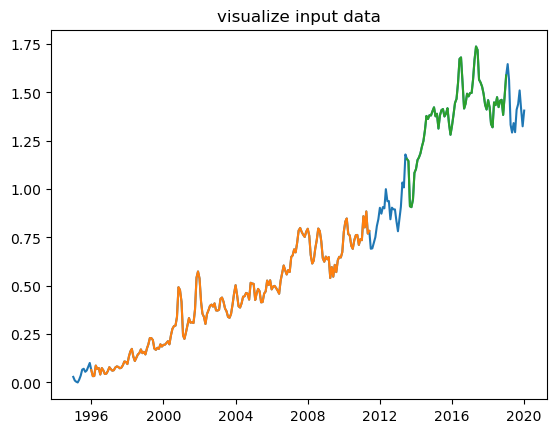

In [49]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [50]:
ar_rnn_model = AR_RNN(
    units=256,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_rnn_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=100,
                             patience=20)


Epoch 1/100
6/6 [==============================] - 5s 210ms/step - loss: 0.2893 - mean_absolute_error: 0.3964 - val_loss: 1.3730 - val_mean_absolute_error: 0.8905
Epoch 2/100
6/6 [==============================] - 0s 32ms/step - loss: 0.0647 - mean_absolute_error: 0.1970 - val_loss: 1.4139 - val_mean_absolute_error: 0.9221
Epoch 3/100
6/6 [==============================] - 0s 34ms/step - loss: 0.0407 - mean_absolute_error: 0.1535 - val_loss: 1.1984 - val_mean_absolute_error: 0.8578
Epoch 4/100
6/6 [==============================] - 0s 32ms/step - loss: 0.0279 - mean_absolute_error: 0.1257 - val_loss: 1.1207 - val_mean_absolute_error: 0.7975
Epoch 5/100
6/6 [==============================] - 0s 51ms/step - loss: 0.0210 - mean_absolute_error: 0.1081 - val_loss: 0.9696 - val_mean_absolute_error: 0.7258
Epoch 6/100
6/6 [==============================] - 0s 34ms/step - loss: 0.0174 - mean_absolute_error: 0.0999 - val_loss: 0.9534 - val_mean_absolute_error: 0.7279
Epoch 7/100
6/6 [==========

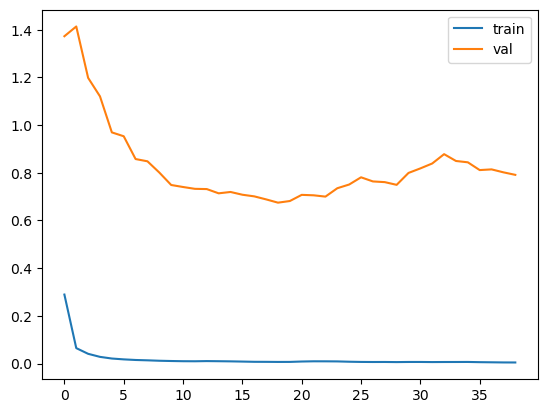

In [51]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [52]:
pred_train = ar_rnn_model.predict(X_train)  #[:, -1]
pred_test = ar_rnn_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])
pred_12mo_train_rescaled = scaler.inverse_transform(pred_train[:, -1])
pred_12mo_test_rescaled = scaler.inverse_transform(pred_test[:, -1])


3/3 [==============================] - 0s 8ms/step


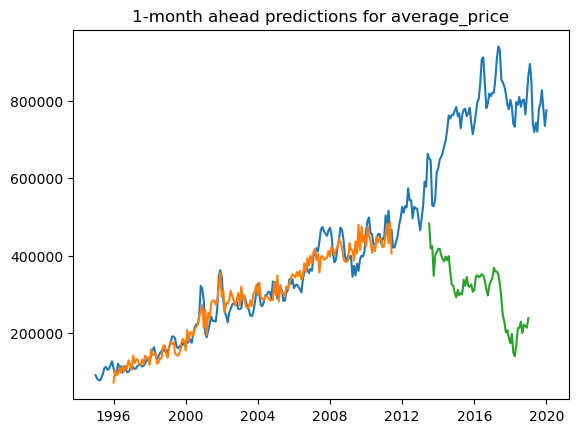

In [53]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


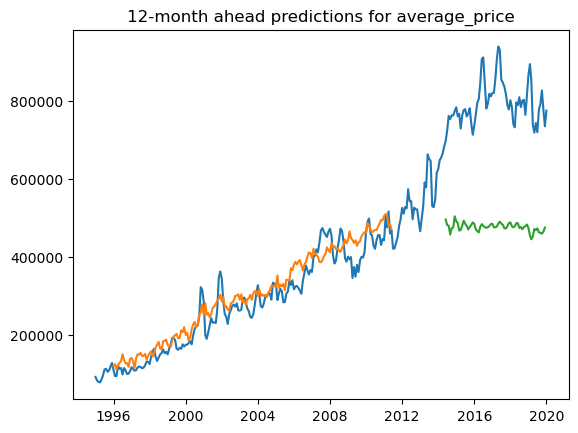

In [54]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_12mo_train_rescaled,
                    test_ts=pred_12mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=11,
                    title=f'12-month ahead predictions for {cols[col_idx]}')


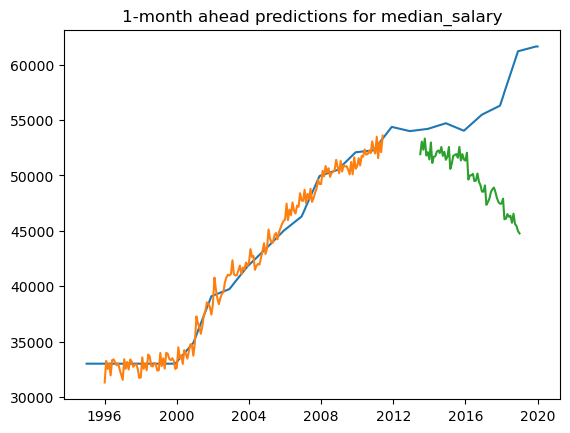

In [55]:
col_idx = 4
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


In [56]:
y_1mo_train_rescaled = scaler.inverse_transform(y_train[:, 0])
y_1mo_test_rescaled = scaler.inverse_transform(y_test[:, 0])
y_12mo_train_rescaled = scaler.inverse_transform(y_train[:, -1])
y_12mo_test_rescaled = scaler.inverse_transform(y_test[:, -1])

In [57]:
y_1mo_train_rescaled.shape

(186, 8)

In [58]:
print('Train 1mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_train_rescaled[:, 0],
                           y_1mo_train_rescaled[:, 0]))))
print('Test 1mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_test_rescaled[:, 0],
                           y_1mo_test_rescaled[:, 0]))))

print('Train 12mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_12mo_train_rescaled[:, 0],
                           y_12mo_train_rescaled[:, 0]))))
print('Test 12mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_12mo_test_rescaled[:, 0],
                           y_12mo_test_rescaled[:, 0]))))


Train 1mo RMSE: 32382.578810457853
Test 1mo RMSE: 476703.1518201556
Train 12mo RMSE: 33487.35065214482
Test 12mo RMSE: 322834.8785852559


### predict diff

#### data

In [59]:
cols = ['average_price_d1']
lookback = 12
lookforward = 12
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [60]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(186, 12, 1)
(186, 12, 1)
(67, 12, 1)
(67, 12, 1)


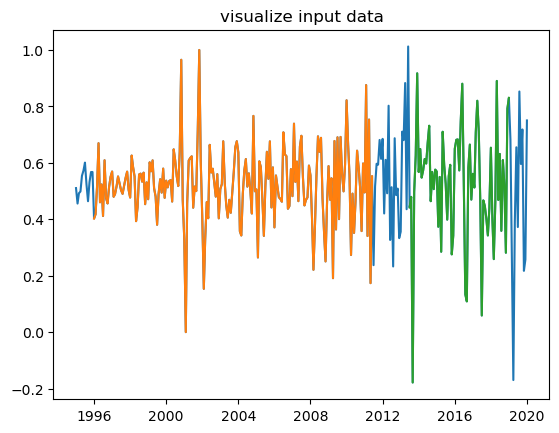

In [61]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [62]:
ar_rnn_model = AR_RNN(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_rnn_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


Epoch 1/50
6/6 [==============================] - 8s 490ms/step - loss: 0.1554 - mean_absolute_error: 0.3041 - val_loss: 0.0886 - val_mean_absolute_error: 0.2350
Epoch 2/50
6/6 [==============================] - 0s 38ms/step - loss: 0.0331 - mean_absolute_error: 0.1418 - val_loss: 0.0592 - val_mean_absolute_error: 0.2012
Epoch 3/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0308 - mean_absolute_error: 0.1433 - val_loss: 0.0471 - val_mean_absolute_error: 0.1722
Epoch 4/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0195 - mean_absolute_error: 0.1051 - val_loss: 0.0476 - val_mean_absolute_error: 0.1637
Epoch 5/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0202 - mean_absolute_error: 0.1074 - val_loss: 0.0426 - val_mean_absolute_error: 0.1576
Epoch 6/50
6/6 [==============================] - 0s 37ms/step - loss: 0.0176 - mean_absolute_error: 0.0998 - val_loss: 0.0441 - val_mean_absolute_error: 0.1661
Epoch 7/50
6/6 [=================

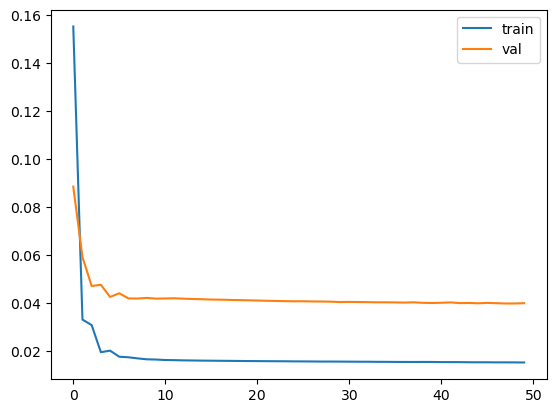

In [63]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [64]:
pred_train = ar_rnn_model.predict(X_train)  #[:, -1]
pred_test = ar_rnn_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])
pred_12mo_train_rescaled = scaler.inverse_transform(pred_train[:, -1])
pred_12mo_test_rescaled = scaler.inverse_transform(pred_test[:, -1])


3/3 [==============================] - 0s 6ms/step


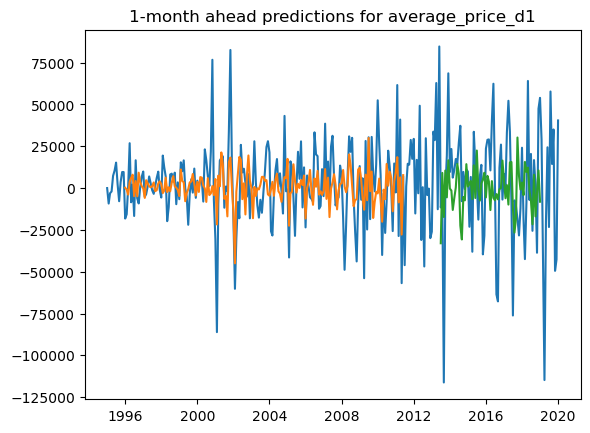

In [65]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


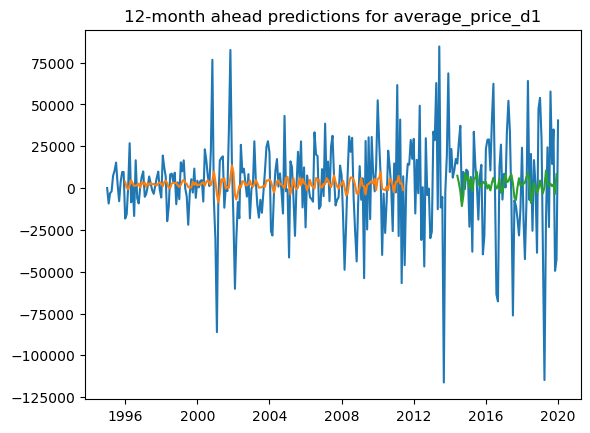

In [66]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_12mo_train_rescaled,
                    test_ts=pred_12mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=11,
                    title=f'12-month ahead predictions for {cols[col_idx]}')


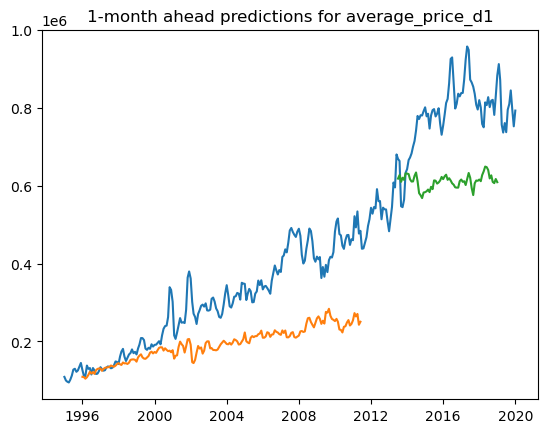

In [67]:
plot_cumulative(area_data=area_data,
                ground_truth_diff=pd.concat([train_df[cols], test_df[cols]]),
                train_ts_diff=pred_1mo_train_rescaled,
                test_ts_diff=pred_1mo_test_rescaled,
                cols=cols,
                col_idx=col_idx,
                lookback=lookback,
                lookforward=lookforward,
                fwd_offset=0,
                title=f'1-month ahead predictions for {cols[col_idx]}')


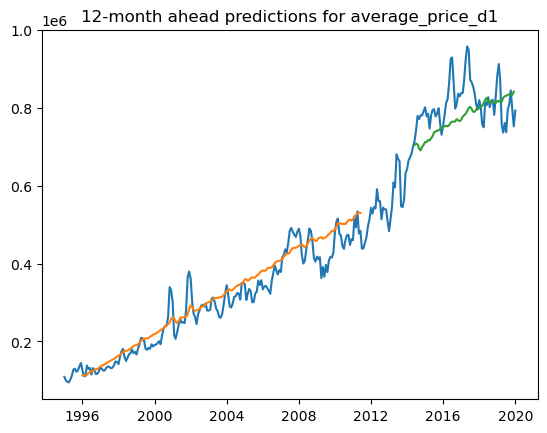

In [68]:
plot_cumulative(area_data=area_data,
                ground_truth_diff=pd.concat([train_df[cols], test_df[cols]]),
                train_ts_diff=pred_12mo_train_rescaled,
                test_ts_diff=pred_12mo_test_rescaled,
                cols=cols,
                col_idx=col_idx,
                lookback=lookback,
                lookforward=lookforward,
                fwd_offset=11,
                title=f'12-month ahead predictions for {cols[col_idx]}')
